In [ ]:
# ===== Step 1: Import Libraries =====
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

# ===== Step 2: Load Data =====
# Mount Google Drive to access files stored in your Drive from Colab
from google.colab import drive
drive.mount('/content/drive')

# Define the file path to the MBTI dataset stored in Google Drive
file_path = '/content/drive/MyDrive/MBTI_Project/mbti_1.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first 5 rows of the DataFrame to preview the data
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
# ===== Step 3: Split MBTI type into 4 binary traits =====
df['IE'] = df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
df['NS'] = df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
df['TF'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df['JP'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)


In [ ]:
# ===== Step 4: Data Cleaning =====


# Define English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Full clean function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = remove_emoji(text)  # Remove emojis
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply the cleaning function to the 'posts' column
df['clean_posts'] = df['posts'].apply(clean_text)

# Preview the cleaned data
df[['type', 'clean_posts']].head()



,type,clean_posts
0,INFJ,intj moments sportscenter top ten plays pranks...
1,ENTP,im finding lack posts alarmingsex boring posit...
2,INTP,good one course say know thats blessing cursed...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,youre firedthats another silly misconception a...


In [ ]:
# ===== Step 5: TF-IDF Vectorization =====
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Apply TF-IDF to the cleaned posts
X = tfidf.fit_transform(df['clean_posts'])

# Print the shape of the feature matrix
print("TF-IDF feature matrix shape:", X.shape)

# ===== Step 6: Prepare Labels =====
# Prepare labels (4 binary traits)
y_IE = df['IE']
y_NS = df['NS']
y_TF = df['TF']
y_JP = df['JP']

# ===== Step 7: Train-Validation-Test Split (70-15-15) =====
# First, split into 85% train+val and 15% test set using shared row indices
X_temp, X_test, idx_temp, idx_test = train_test_split(
    X, df.index, test_size=0.15, random_state=42)

# Then split the 85% into 70% train and 15% val (15/85 ≈ 0.1765)
X_train, X_val, idx_train, idx_val = train_test_split(
    X_temp, idx_temp, test_size=0.1765, random_state=42)

# ===== Step 8: Slice trait labels using shared indices =====
# IE trait
y_train_IE = df.loc[idx_train, 'IE']
y_val_IE   = df.loc[idx_val, 'IE']
y_test_IE  = df.loc[idx_test, 'IE']

# NS trait
y_train_NS = df.loc[idx_train, 'NS']
y_val_NS   = df.loc[idx_val, 'NS']
y_test_NS  = df.loc[idx_test, 'NS']

# TF trait
y_train_TF = df.loc[idx_train, 'TF']
y_val_TF   = df.loc[idx_val, 'TF']
y_test_TF  = df.loc[idx_test, 'TF']

# JP trait
y_train_JP = df.loc[idx_train, 'JP']
y_val_JP   = df.loc[idx_val, 'JP']
y_test_JP  = df.loc[idx_test, 'JP']

# ===== Step 9: Confirm shape consistency =====
print("✅ Data split complete:")
print(f"Train:     {X_train.shape}")
print(f"Validation:{X_val.shape}")
print(f"Test:      {X_test.shape}")




TF-IDF feature matrix shape: (8675, 3000)
✅ Data split complete:
Train:     (6071, 3000)
Validation:(1302, 3000)
Test:      (1302, 3000)


In [ ]:
# ===== Step 10: Print Shape and Sample Data =====

# Print the shape of shared TF-IDF feature matrix across all traits
print("TF-IDF Feature Matrix Shapes:")
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)
print("\n")

# Print the shape of each label vector for sanity check
print("Label Shapes:")
print("IE:", y_train_IE.shape, y_val_IE.shape, y_test_IE.shape) # Changed y_IE_test to y_test_IE
print("NS:", y_train_NS.shape, y_val_NS.shape, y_test_NS.shape) # Changed y_NS_test to y_test_NS
print("TF:", y_train_TF.shape, y_val_TF.shape, y_test_TF.shape) # Changed y_TF_test to y_test_TF
print("JP:", y_train_JP.shape, y_val_JP.shape, y_test_JP.shape) # Changed y_JP_test to y_test_JP
print("\n")

# Show sample TF-IDF vectors (dense format)
print("Sample TF-IDF features (first 5 training samples):")
print(X_train[:5].toarray())  # Convert sparse matrix to dense array for display

# Show first 5 IE labels
print("\nSample labels (IE):")
print(y_train_IE[:5].values)

TF-IDF Feature Matrix Shapes:
Training set: (6071, 3000)
Validation set: (1302, 3000)
Test set: (1302, 3000)


Label Shapes:
IE: (6071,) (1302,) (1302,)
NS: (6071,) (1302,) (1302,)
TF: (6071,) (1302,) (1302,)
JP: (6071,) (1302,) (1302,)


Sample TF-IDF features (first 5 training samples):
[[0.         0.         0.04234622 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0373613  0.05174337 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.03248124 0.         0.        ]]

Sample labels (IE):
[1 0 1 1 1]


**Explanation of the Output:**

The output shows the shape and sample content of the processed dataset for the IE (Introversion/Extroversion) trait classification. The training, validation, and test sets are split in a 70-15-15 ratio, with each sample represented by a 3000-dimensional TF-IDF feature vector. These numerical values indicate the importance of specific words in the user's social media posts. Most values are zeros because each post contains only a small subset of the entire vocabulary (sparse matrix). The sample labels correspond to the binary IE trait, where 1 indicates Introversion and 0 indicates Extroversion.

In [ ]:
!pip install -q xgboost


Recommended scale_pos_weight: 0.30615318416523235
[0]	validation_0-logloss:0.66494
[1]	validation_0-logloss:0.64007
[2]	validation_0-logloss:0.61979
[3]	validation_0-logloss:0.60132
[4]	validation_0-logloss:0.58625
[5]	validation_0-logloss:0.57071
[6]	validation_0-logloss:0.55956
[7]	validation_0-logloss:0.54852
[8]	validation_0-logloss:0.53837
[9]	validation_0-logloss:0.53071
[10]	validation_0-logloss:0.52374
[11]	validation_0-logloss:0.51536
[12]	validation_0-logloss:0.50993
[13]	validation_0-logloss:0.50399
[14]	validation_0-logloss:0.49853
[15]	validation_0-logloss:0.49345
[16]	validation_0-logloss:0.48943
[17]	validation_0-logloss:0.48500
[18]	validation_0-logloss:0.48145
[19]	validation_0-logloss:0.47766
[20]	validation_0-logloss:0.47485
[21]	validation_0-logloss:0.47125
[22]	validation_0-logloss:0.46896
[23]	validation_0-logloss:0.46558
[24]	validation_0-logloss:0.46295
[25]	validation_0-logloss:0.46118
[26]	validation_0-logloss:0.45939
[27]	validation_0-logloss:0.45696
[28]	val

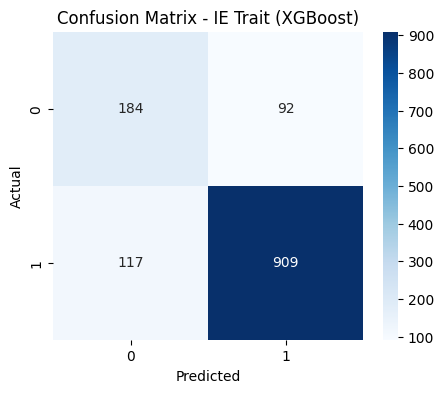

In [ ]:
# ===== Step 1: Initialize and train the XGBoost model =====
import xgboost as xgb
# Count the number of negative (Extroversion) and positive (Introversion) samples in the training set
neg, pos = np.bincount(y_train_IE)

# Calculate the recommended scale_pos_weight (negative samples / positive samples)
scale_IE = neg / pos

# Print the recommended weight to address class imbalance
print(f"Recommended scale_pos_weight: {scale_IE}")

# Slice the feature matrix X to get X_train_IE and X_val_IE
X_train_IE = X[idx_train] # Select rows from X corresponding to training indices
X_val_IE = X[idx_val]     # Select rows from X corresponding to validation indices


xgb_model_IE = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=scale_IE,
    random_state=42
)

xgb_model_IE.fit(X_train_IE, y_train_IE, eval_set=[(X_val_IE, y_val_IE)], verbose=True)

# ===== Step 2: Evaluate on test set =====
y_pred_IE = xgb_model_IE.predict(X_test)
accuracy = accuracy_score(y_test_IE, y_pred_IE) # Changed y_IE_test to y_test_IE
print(f"XGBoost Test Accuracy (IE): {accuracy:.4f}")

print("\nClassification Report (IE):")
print(classification_report(y_test_IE, y_pred_IE)) # Changed y_IE_test to y_test_IE

# ===== Step 3: Plot Confusion Matrix =====
cm = confusion_matrix(y_test_IE, y_pred_IE) # Changed y_IE_test to y_test_IE
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - IE Trait (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We applied class weight adjustment to address the imbalanced class distribution. As a result, the recall of the Extroversion class improved from 50% to 67%, with a slight trade-off in overall accuracy.

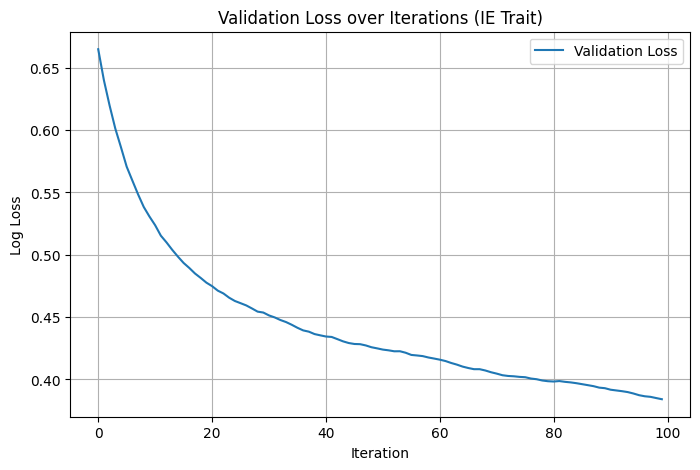

In [ ]:
import matplotlib.pyplot as plt

# Get training history
results = xgb_model_IE.evals_result()

# Plot log loss over iterations
plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['logloss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Validation Loss over Iterations (IE Trait)')
plt.legend()
plt.grid(True)
plt.show()


**Training Process Visualization (IE Trait):**

The validation log loss curve for the IE trait shows a smooth and consistent decrease throughout the training process. The loss stabilizes after approximately 60 iterations, indicating that the model has successfully converged without signs of overfitting. This demonstrates that the XGBoost model was able to effectively learn the patterns associated with the IE trait from the training data.

=== Training XGBoost for NS Trait ===
Recommended scale_pos_weight: 0.15660125738235856
[0]	validation_0-logloss:0.66646
[1]	validation_0-logloss:0.64292
[2]	validation_0-logloss:0.62318
[3]	validation_0-logloss:0.60477
[4]	validation_0-logloss:0.58833
[5]	validation_0-logloss:0.57446
[6]	validation_0-logloss:0.56121
[7]	validation_0-logloss:0.54827
[8]	validation_0-logloss:0.53751
[9]	validation_0-logloss:0.52913
[10]	validation_0-logloss:0.51963
[11]	validation_0-logloss:0.51251
[12]	validation_0-logloss:0.50456
[13]	validation_0-logloss:0.49877
[14]	validation_0-logloss:0.49225
[15]	validation_0-logloss:0.48639
[16]	validation_0-logloss:0.48037
[17]	validation_0-logloss:0.47452
[18]	validation_0-logloss:0.46930
[19]	validation_0-logloss:0.46385
[20]	validation_0-logloss:0.45903
[21]	validation_0-logloss:0.45619
[22]	validation_0-logloss:0.45186
[23]	validation_0-logloss:0.44762
[24]	validation_0-logloss:0.44508
[25]	validation_0-logloss:0.44060
[26]	validation_0-logloss:0.43793
[27]

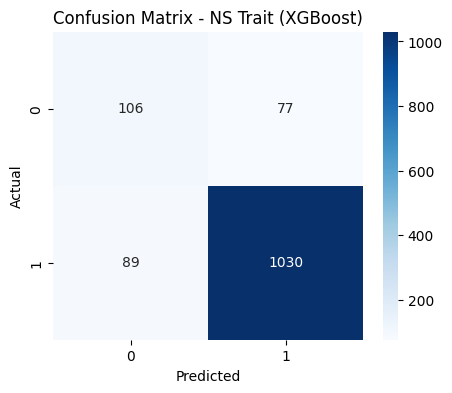

In [ ]:
# ===== NS Trait =====
print("=== Training XGBoost for NS Trait ===")
# Count the number of negative (Extroversion) and positive (Introversion) samples in the training set
neg, pos = np.bincount(y_train_NS)

# Calculate the recommended scale_pos_weight (negative samples / positive samples)
scale_NS = neg / pos

# Print the recommended weight to address class imbalance
print(f"Recommended scale_pos_weight: {scale_NS}")

# Slice the feature matrix X to get X_train_NS and X_val_NS using the shared indices
X_train_NS = X[idx_train]  # Select rows from X corresponding to training indices
X_val_NS = X[idx_val]      # Select rows from X corresponding to validation indices


xgb_model_NS = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=scale_NS,
    random_state=42
)

xgb_model_NS.fit(X_train_NS, y_train_NS, eval_set=[(X_val_NS, y_val_NS)], verbose=True)

y_pred_NS = xgb_model_NS.predict(X_test)
# Assuming y_NS_test is defined similarly to y_test_IE in previous cells
accuracy_NS = accuracy_score(y_test_NS, y_pred_NS)  # Use y_test_NS
print(f"\nXGBoost Test Accuracy (NS): {accuracy_NS:.4f}")
print("\nClassification Report (NS):")
print(classification_report(y_test_NS, y_pred_NS))  # Use y_test_NS

cm_NS = confusion_matrix(y_test_NS, y_pred_NS)  # Use y_test_NS
plt.figure(figsize=(5, 4))
sns.heatmap(cm_NS, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - NS Trait (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Explanation:**

In the NS trait classification, I observed a significant class imbalance, with the "Intuition (N)" class being much more frequent than the "Sensing (S)" class. This caused the model to favor the majority class and resulted in a low recall score for the minority class (Sensing). To address this issue, I applied the scale_pos_weight parameter in the XGBoost classifier, which adjusts the weight of positive and negative classes based on their frequency. This technique helps the model pay more attention to the minority class and improves overall balance in prediction performance.

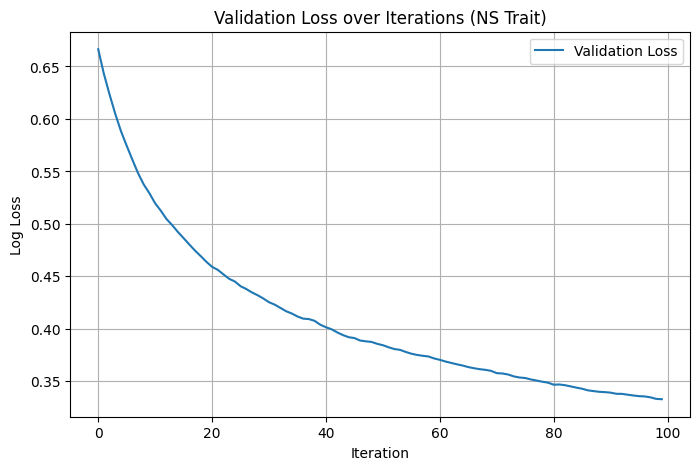

In [ ]:
import matplotlib.pyplot as plt

# Get training history
results = xgb_model_NS.evals_result()

# Plot log loss over iterations
plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['logloss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Validation Loss over Iterations (NS Trait)')
plt.legend()
plt.grid(True)
plt.show()



=== Training XGBoost for TF Trait ===
[0]	validation_0-logloss:0.65943
[1]	validation_0-logloss:0.63414
[2]	validation_0-logloss:0.61422
[3]	validation_0-logloss:0.59644
[4]	validation_0-logloss:0.58317
[5]	validation_0-logloss:0.56936
[6]	validation_0-logloss:0.55750
[7]	validation_0-logloss:0.54706
[8]	validation_0-logloss:0.53719
[9]	validation_0-logloss:0.52873
[10]	validation_0-logloss:0.52084
[11]	validation_0-logloss:0.51312
[12]	validation_0-logloss:0.50730
[13]	validation_0-logloss:0.50210
[14]	validation_0-logloss:0.49630
[15]	validation_0-logloss:0.49022
[16]	validation_0-logloss:0.48662
[17]	validation_0-logloss:0.48152
[18]	validation_0-logloss:0.47730
[19]	validation_0-logloss:0.47196
[20]	validation_0-logloss:0.46836
[21]	validation_0-logloss:0.46493
[22]	validation_0-logloss:0.46212
[23]	validation_0-logloss:0.45904
[24]	validation_0-logloss:0.45782
[25]	validation_0-logloss:0.45395
[26]	validation_0-logloss:0.45162
[27]	validation_0-logloss:0.44908
[28]	validation_0-l

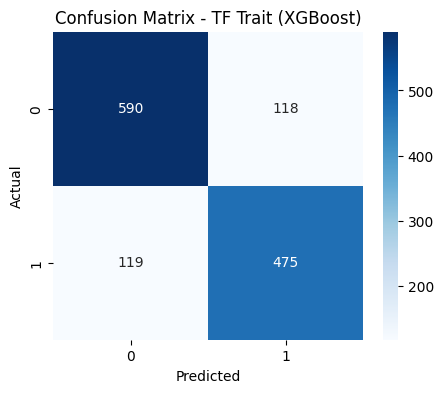

In [ ]:
# ===== TF Trait =====
print("\n=== Training XGBoost for TF Trait ===")

# Slice the feature matrix X to get X_train_TF and X_val_TF using the shared indices
X_train_TF = X[idx_train]  # Select rows from X corresponding to training indices
X_val_TF = X[idx_val]      # Select rows from X corresponding to validation indices


xgb_model_TF = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    #scale_pos_weight=scale,
    random_state=42
)

xgb_model_TF.fit(X_train_TF, y_train_TF, eval_set=[(X_val_TF, y_val_TF)], verbose=True)

y_pred_TF = xgb_model_TF.predict(X_test)
accuracy_TF = accuracy_score(y_test_TF, y_pred_TF) # Changed y_TF_test to y_test_TF
print(f"\nXGBoost Test Accuracy (TF): {accuracy_TF:.4f}")
print("\nClassification Report (TF):")
print(classification_report(y_test_TF, y_pred_TF)) # Changed y_TF_test to y_test_TF

cm_TF = confusion_matrix(y_test_TF, y_pred_TF) # Changed y_TF_test to y_test_TF
plt.figure(figsize=(5, 4))
sns.heatmap(cm_TF, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TF Trait (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

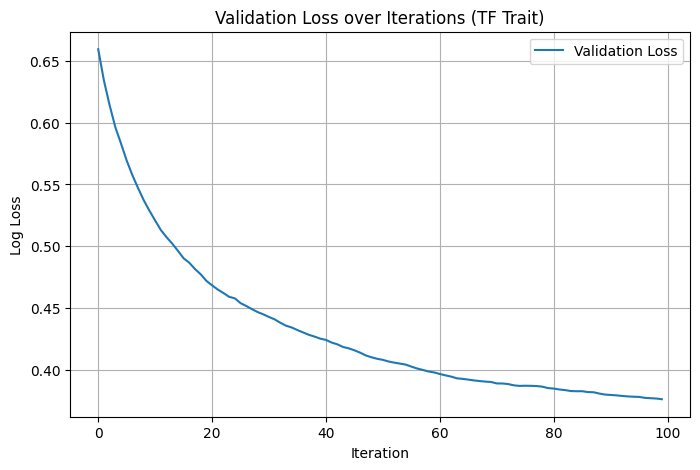

In [ ]:
# Get training history
results = xgb_model_TF.evals_result()

# Plot log loss over iterations
plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['logloss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Validation Loss over Iterations (TF Trait)')
plt.legend()
plt.grid(True)
plt.show()


=== Training XGBoost for JP Trait ===
[0]	validation_0-logloss:0.65476
[1]	validation_0-logloss:0.63448
[2]	validation_0-logloss:0.61718
[3]	validation_0-logloss:0.60208
[4]	validation_0-logloss:0.58795
[5]	validation_0-logloss:0.57718
[6]	validation_0-logloss:0.56741
[7]	validation_0-logloss:0.55678
[8]	validation_0-logloss:0.54753
[9]	validation_0-logloss:0.53975
[10]	validation_0-logloss:0.53314
[11]	validation_0-logloss:0.52726
[12]	validation_0-logloss:0.52147
[13]	validation_0-logloss:0.51581
[14]	validation_0-logloss:0.51000
[15]	validation_0-logloss:0.50564
[16]	validation_0-logloss:0.50131
[17]	validation_0-logloss:0.49749
[18]	validation_0-logloss:0.49462
[19]	validation_0-logloss:0.48983
[20]	validation_0-logloss:0.48648
[21]	validation_0-logloss:0.48415
[22]	validation_0-logloss:0.48032
[23]	validation_0-logloss:0.47837
[24]	validation_0-logloss:0.47692
[25]	validation_0-logloss:0.47494
[26]	validation_0-logloss:0.47139
[27]	validation_0-logloss:0.47018
[28]	validation_0-l

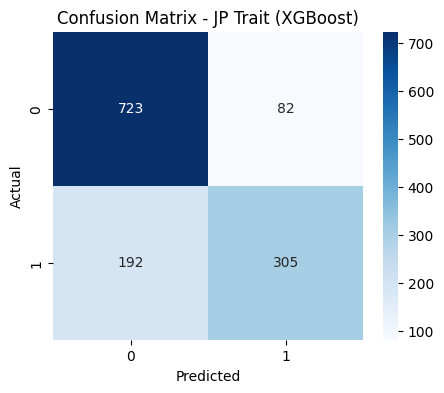

In [ ]:
# ===== JP Trait =====
print("\n=== Training XGBoost for JP Trait ===")

# Slice the feature matrix X to get X_train_JP and X_val_JP using the shared indices
X_train_JP = X[idx_train]  # Select rows from X corresponding to training indices
X_val_JP = X[idx_val]      # Select rows from X corresponding to validation indices


xgb_model_JP = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

xgb_model_JP.fit(X_train_JP, y_train_JP, eval_set=[(X_val_JP, y_val_JP)], verbose=True)

y_pred_JP = xgb_model_JP.predict(X_test)
# Assuming y_test_JP is defined similarly to y_test_IE in previous cells
accuracy_JP = accuracy_score(y_test_JP, y_pred_JP) # Use y_test_JP for consistency
print(f"\nXGBoost Test Accuracy (JP): {accuracy_JP:.4f}")
print("\nClassification Report (JP):")
print(classification_report(y_test_JP, y_pred_JP)) # Use y_test_JP for consistency

cm_JP = confusion_matrix(y_test_JP, y_pred_JP) # Use y_test_JP for consistency
plt.figure(figsize=(5, 4))
sns.heatmap(cm_JP, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - JP Trait (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

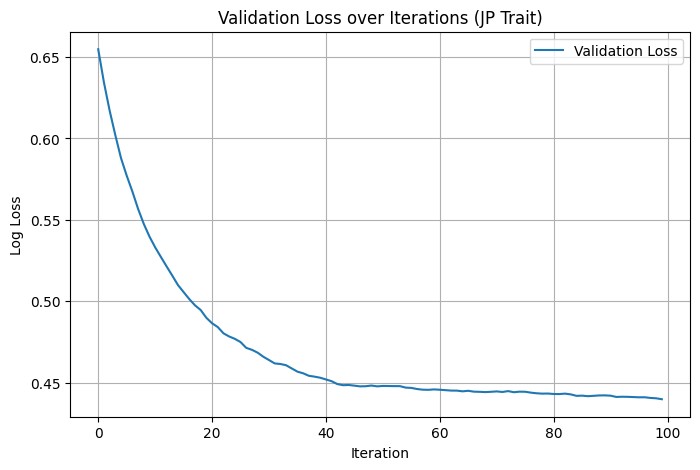

In [ ]:
# Get training history
results = xgb_model_JP.evals_result()

# Plot log loss over iterations
plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['logloss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Validation Loss over Iterations (JP Trait)')
plt.legend()
plt.grid(True)
plt.show()


Logistic Regression Test Accuracy (IE): 0.8318

Classification Report (IE):
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       276
           1       0.91      0.87      0.89      1026

    accuracy                           0.83      1302
   macro avg       0.75      0.78      0.76      1302
weighted avg       0.84      0.83      0.84      1302



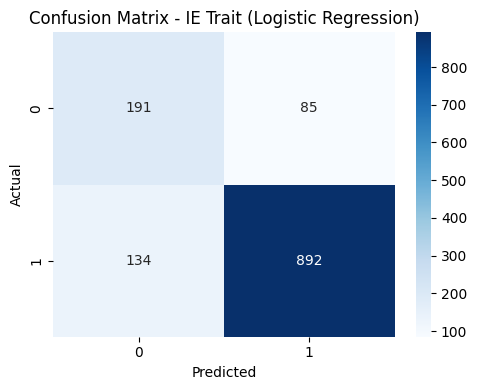

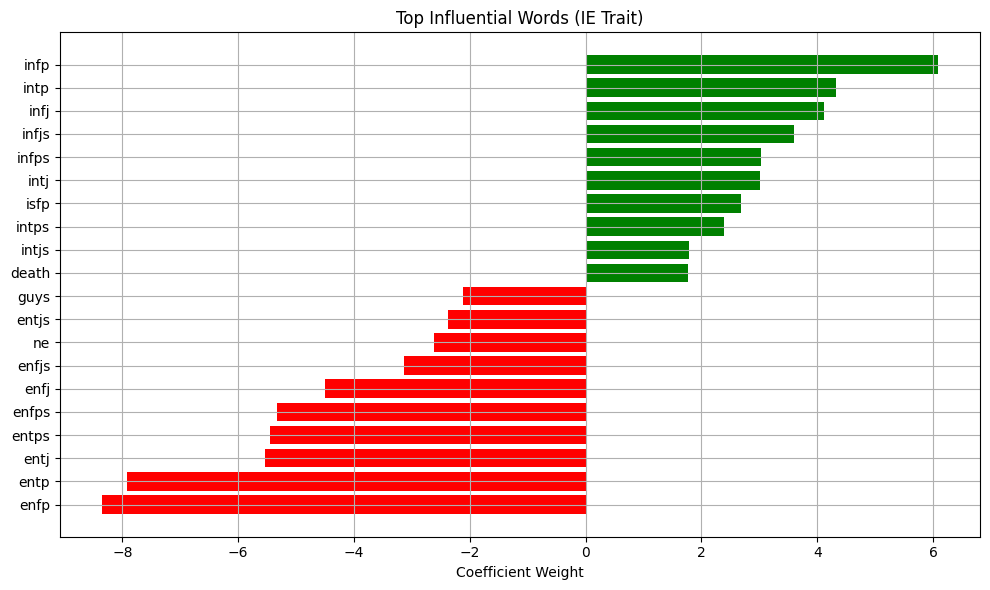


Logistic Regression Test Accuracy (NS): 0.8810

Classification Report (NS):
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       183
           1       0.95      0.91      0.93      1119

    accuracy                           0.88      1302
   macro avg       0.76      0.81      0.78      1302
weighted avg       0.90      0.88      0.89      1302



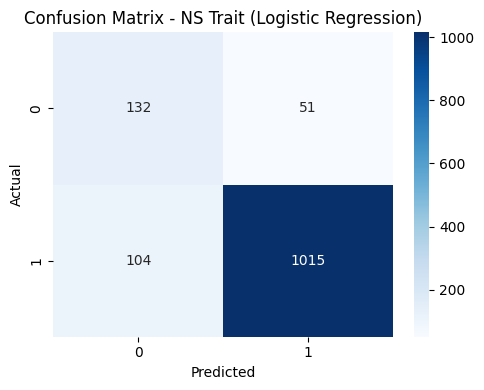

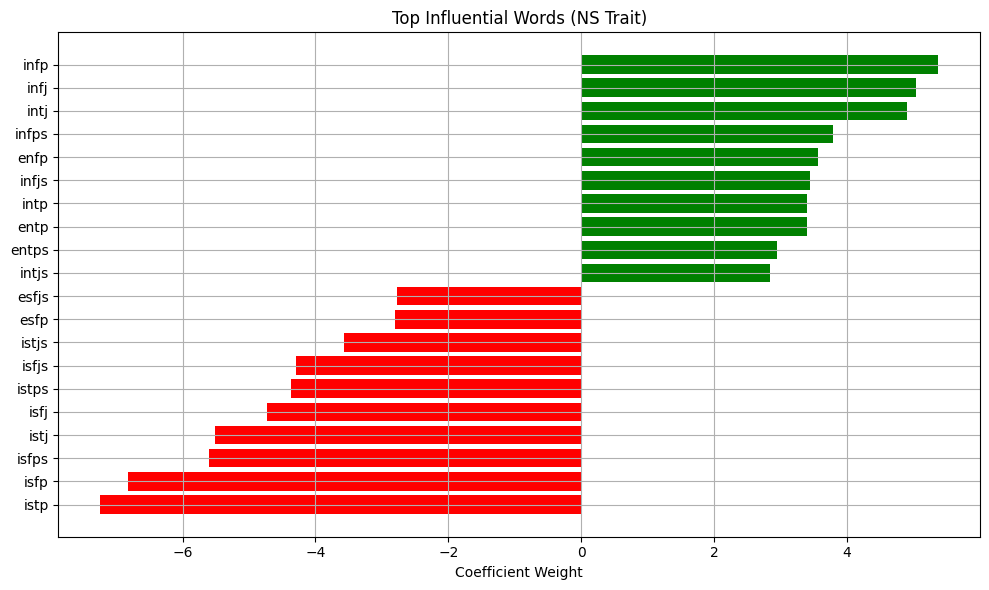


Logistic Regression Test Accuracy (TF): 0.8425

Classification Report (TF):
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       708
           1       0.83      0.83      0.83       594

    accuracy                           0.84      1302
   macro avg       0.84      0.84      0.84      1302
weighted avg       0.84      0.84      0.84      1302



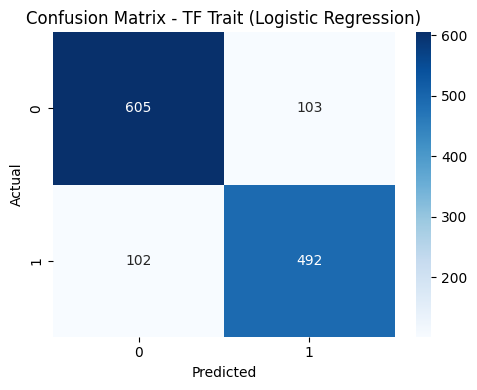

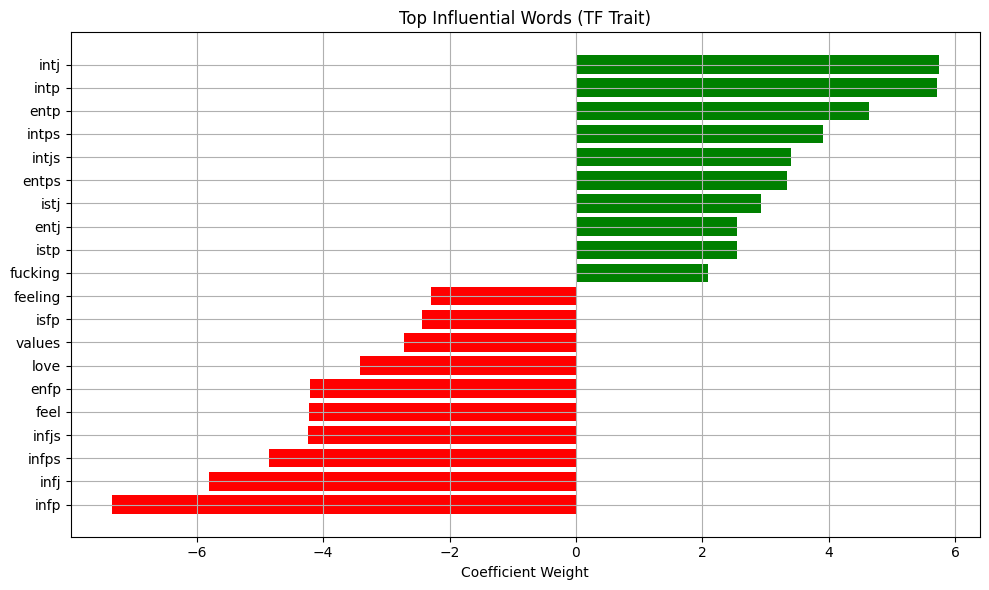


Logistic Regression Test Accuracy (JP): 0.7949

Classification Report (JP):
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       805
           1       0.81      0.61      0.69       497

    accuracy                           0.79      1302
   macro avg       0.80      0.76      0.77      1302
weighted avg       0.80      0.79      0.79      1302



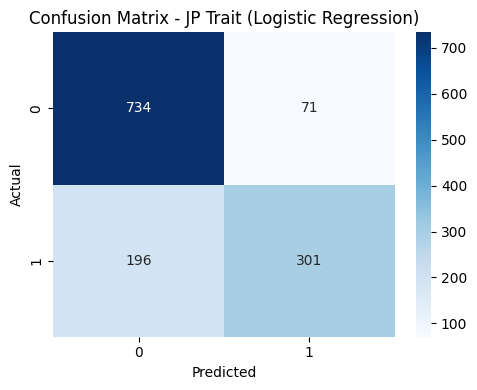

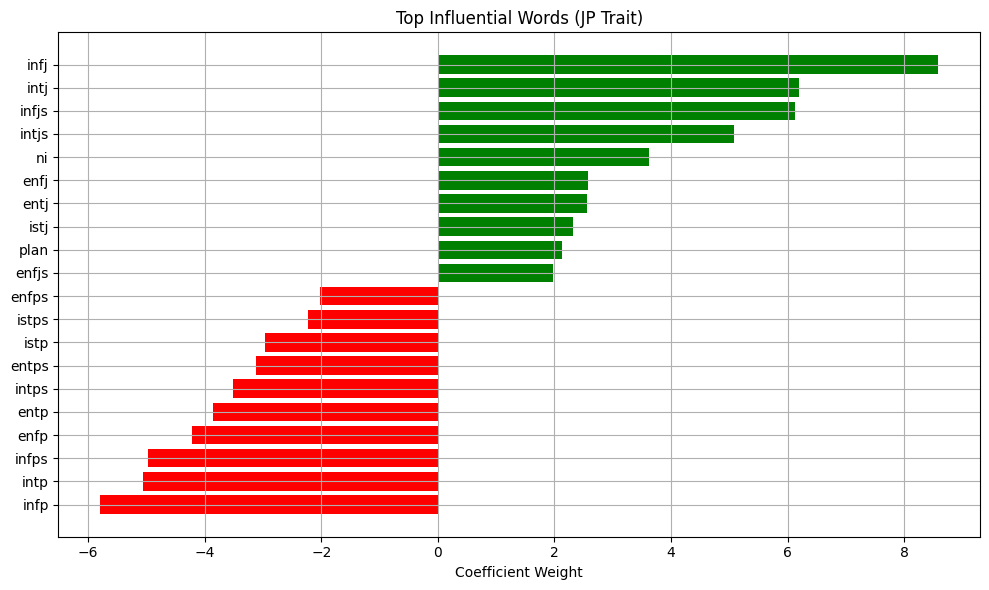

[22]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Retrieve all token (word) feature names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# General-purpose function: Train and visualize a Logistic Regression model
def train_and_visualize_logistic_regression(X_train, y_train, X_test, y_test, trait_name, class_weight=None):
    """
    Train a logistic regression model and visualize both confusion matrix and feature weights.

    Parameters:
    - X_train, y_train: training data
    - X_test, y_test: testing data
    - trait_name: one of "IE", "NS", "TF", or "JP"
    - class_weight: "balanced" or None (to handle imbalanced datasets)
    """
    # Initialize logistic regression with chosen settings
    model = LogisticRegression(
        class_weight=class_weight,  # Adjust weights for imbalanced classes
        solver='saga',              # Supports large, sparse datasets and enables convergence diagnostics
        max_iter=1000,
        verbose=0,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # ===== Step 1: Evaluate Model Performance =====
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nLogistic Regression Test Accuracy ({trait_name}): {accuracy:.4f}")
    print(f"\nClassification Report ({trait_name}):")
    print(classification_report(y_test, y_pred))

    # ===== Step 2: Plot Confusion Matrix =====
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {trait_name} Trait (Logistic Regression)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ===== Step 3: Visualize Top Feature Weights =====
    if hasattr(model, "coef_"):
        coefs = model.coef_[0]
        topn = 10
        top_pos = coefs.argsort()[-topn:]  # Most positive weights (class 1)
        top_neg = coefs.argsort()[:topn]   # Most negative weights (class 0)
        top_idx = list(top_neg) + list(top_pos)
        top_weights = coefs[top_idx]
        top_features = feature_names[top_idx]

        colors = ['red' if w < 0 else 'green' for w in top_weights]

        plt.figure(figsize=(10, 6))
        plt.barh(top_features, top_weights, color=colors)
        plt.xlabel("Coefficient Weight")
        plt.title(f"Top Influential Words ({trait_name} Trait)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return model


# ===== Execute training and visualization for all four MBTI traits =====
# Corrected the variable names for the test set labels
lr_model_IE = train_and_visualize_logistic_regression(X_train_IE, y_train_IE, X_test, y_test_IE, "IE", class_weight='balanced')
lr_model_NS = train_and_visualize_logistic_regression(X_train_NS, y_train_NS, X_test, y_test_NS, "NS", class_weight='balanced')
lr_model_TF = train_and_visualize_logistic_regression(X_train_TF, y_train_TF, X_test, y_test_TF, "TF")
lr_model_JP = train_and_visualize_logistic_regression(X_train_JP, y_train_JP, X_test, y_test_JP, "JP")

print(lr_model_IE.n_iter_)
